In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

In [3]:
df_train=pd.read_csv('SUSY.csv',names=columns,nrows=1500000,engine='python')
df_test=pd.read_csv('SUSY.csv',names=columns,nrows=50000, skiprows=1500000,engine='python')

In [4]:
df_train.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [6]:
df_train1=df_train[0:1000]

Text(0, 0.5, 'lepton 2 pT')

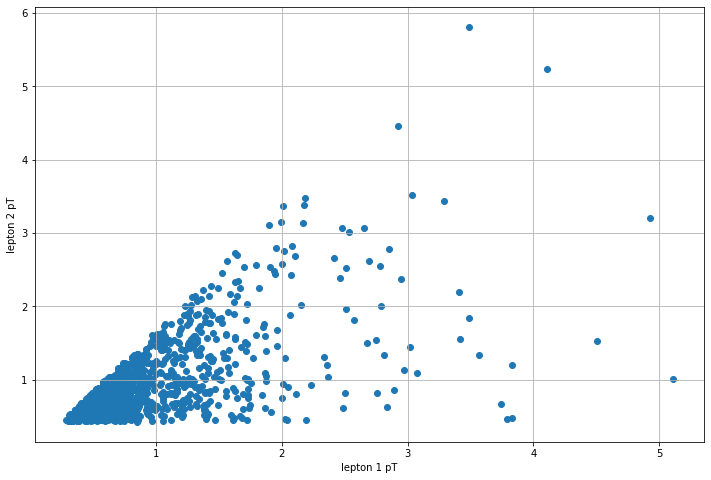

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(df_train1["lepton 1 pT"], df_train1["lepton 2 pT"])
plt.grid()
plt.xlabel("lepton 1 pT")
plt.ylabel("lepton 2 pT")

Text(0, 0.5, 'lepton 1 eta')

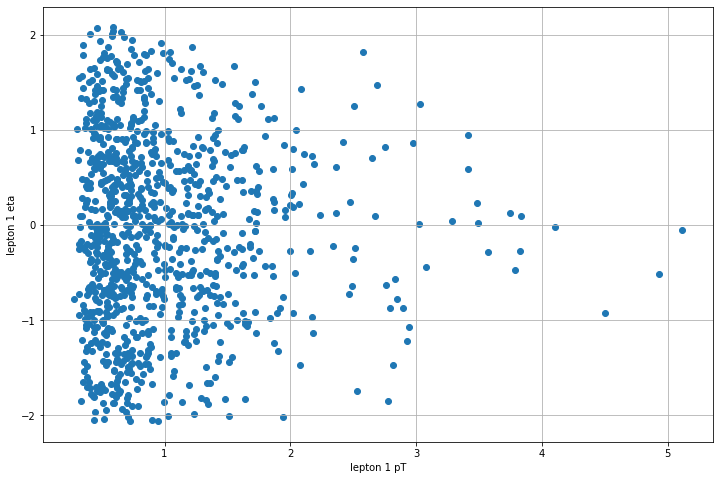

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(df_train1["lepton 1 pT"], df_train1["lepton 1 eta"])
plt.grid()
plt.xlabel("lepton 1 pT")
plt.ylabel("lepton 1 eta")

In [18]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

def getTrainData(nVar):
    designMatrix = df_train.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_train['signal'].values # labels (0 or 1)
    return (designMatrix,labels)

def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_test['signal'].values
    return (designMatrix,labels)

# define
def build_roc_curve(probs, signal_bit, threshes):
    # Convert things to a pandas series to build a DataFrame
    # which will make ROC curve logic easier to express
    signal_probs = pd.Series(probs[:,1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        # define acceptance
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        # sum over data frame with slicing conditions
        nSigCor = len(signal_df[(signal_df['accept']) & (signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[ (signal_df['sig_true']==0.) & (~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig) # False positive rate
        Rejection.append(nBkgCor/nBkg) # True positive rate

    return Acceptance, Rejection
    
# let's define this as a function so we can call it easily
def runTensorFlowRegression(nVar,alpha):

    #make data array placeholder for just first 8 simple features
    x = tf.placeholder(tf.float32,[None,nVar])
    #make weights and bias
    W = tf.Variable(tf.zeros([nVar,2])) #we will make y 'onehot' 0 bit is bkg, 1 bit is signal
    b = tf.Variable(tf.zeros([2]))

    #make 'answer variable'
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    #placeholder for correct answer
    y_ = tf.placeholder(tf.float32, [None, 2])
    #cross entropy with L2 regularizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y,labels=y_)+alpha*tf.nn.l2_loss(W))
    
    #define training step
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    #initialize variables 
    init = tf.global_variables_initializer()
    #setup session
    sess = tf.Session()
    sess.run(init)

    #ok now everything is setup for tensorflow, but we need the data in a useful form
    #first let's get the variables
    Var_train, Sig_train_bit1 = getTrainData(nVar)
    #now the signal
    Sig_train_bit0 = Sig_train_bit1.copy()
    Sig_train_bit0 = 1 - Sig_train_bit0
    Sig_train = np.column_stack((Sig_train_bit0,Sig_train_bit1))
    
    ######## ------- TRAINING ----------############
    #Now perform minibatch gradient descent with minibatches of size 100:
    n_data = len(Sig_train_bit1)
    minibatch_size = 1000
    n_minibatch = n_data//minibatch_size
    print('\t Training with %i minibatches, dataset size is %i'%(n_minibatch,n_data))
    for i in range(0, n_minibatch):
        sys.stdout.write("%.3f %% completed \r"%(100*i/n_minibatch))
        sys.stdout.flush()
        start = i*minibatch_size
        end = (i+1)*minibatch_size-1
        
        batch_x = Var_train[start:end]
        batch_y = Sig_train[start:end]
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})
    
    
    # Accuracy function:
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    ######## ------- TESTING ----------############
    # Setup test data
    Var_test = df_test.iloc[:,1:nVar+1].values
    
    # Now the signal
    Sig_test_bit1 = df_test['signal'].values
    
    Sig_test_bit0 = Sig_test_bit1.copy()
    Sig_test_bit0 = 1 - Sig_test_bit0
    Sig_test = np.column_stack((Sig_test_bit0,Sig_test_bit1))
    print("\t Accuracy for alpha %.1E : %.3f" %(alpha,sess.run(accuracy, feed_dict={x: Var_test, y_: Sig_test})))
    
    # Get the weights
    weights = W.eval(session=sess)
    # Get probabilities assigned (i.e. evaluate y on test data)
    probs = y.eval(feed_dict = {x: Var_test}, session = sess)
    # now let's get the signal efficiency and background rejection on the test data
    print('\t Computing ROC curve ...')
    # build ROC curve by scanning over thresholds of probability of being
    # a background event and calculating signal efficiency/background rejection
    # at each threshold
    threshes = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curve(probs, Sig_test_bit1, threshes)

    return (probs,Acceptance,Rejection)

Training for alpha = 1.00E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.770
	 Computing ROC curve ...
Training for alpha = 7.94E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 7.9E-10 : 0.770
	 Computing ROC curve ...
Training for alpha = 6.31E-09
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 6.3E-09 : 0.770
	 Computing ROC curve ...
Training for alpha = 5.01E-08
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 5.0E-08 : 0.770
	 Computing ROC curve ...
Training for alpha = 3.98E-07
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 4.0E-07 : 0.770
	 Computing ROC curve ...
Training for alpha = 3.16E-06
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 3.2E-06 : 0.770
	 Computing ROC curve ...
Training for alpha = 2.51E-05
	 Training with 1500 minibatches, dataset size is 1500000
	 Accu

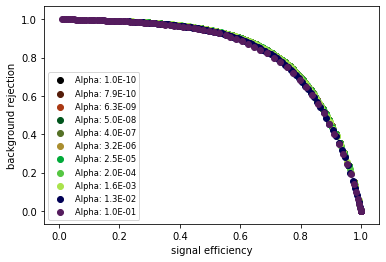

In [19]:
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probsSimple,accep,rej = runTensorFlowRegression(8,alpha)
    ax.scatter(accep,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1
    
ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-05 : 0.770
	 Computing ROC curve ...


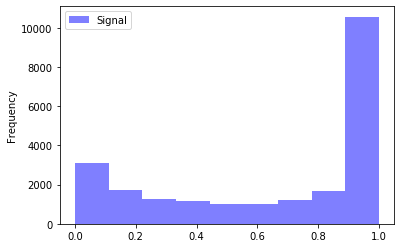

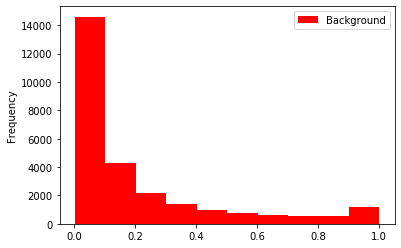

In [20]:
probsSimple,accep,rej = runTensorFlowRegression(8,.00001) # train the model for 8 variables and alpha=.00001
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')